<a href="https://colab.research.google.com/github/HoseinNekouei/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import torch
import pandas as pd
from google.colab import userdata
from torch.optim import AdamW
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification

userdata.get('HF_TOKEN')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
class SentimentAnalysisModel:
    def __init__(self, checkpoint, epochs=2, batch_size=32, n_splits=5):
        self.checkpoint = checkpoint
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.tokenizer, self.model = self.load_model_and_tokenizer()
        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

    def load_model_and_tokenizer(self):
        """Load the tokenizer and model from the specified checkpoint."""
        tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        model = AutoModelForSequenceClassification.from_pretrained(
            self.checkpoint,
            device_map='auto')

        model.to(self.device)
        return tokenizer, model

    def tokenize_texts(self, texts):
        """Tokenize a list of texts using the provided tokenizer."""
        if not isinstance(texts, list):
            texts = texts.tolist()

        encodings = self.tokenizer(
            texts,
            padding=True,
            max_length=256,
            truncation=True,
            return_tensors='pt'
        )
        return encodings

    def prepare_dataloaders(self, input_ids, attention_mask, labels, train_idx, test_idx):
        """Prepare training and test dataloaders."""
        train_dataset = TensorDataset(input_ids[train_idx], attention_mask[train_idx], labels[train_idx])
        test_dataset = TensorDataset(input_ids[test_idx], attention_mask[test_idx], labels[test_idx])

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)
        return train_loader, test_loader

    def train_model(self, train_loader):
        """Train the model for the specified number of epochs."""
        self.model.train()
        for epoch in range(self.epochs):
            for i, batch in enumerate(train_loader):
                self.optimizer.zero_grad()
                input_ids_batch, attention_mask_batch, labels_batch = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                denominator = math.ceil(len(train_loader.dataset) / self.batch_size)
                if (i + 1) % 100 == 0:
                    print(f'[Epoch: {epoch + 1}] -> Batch: [{i + 1}/{denominator}]')

            print(f'[Epoch: {epoch + 1}] -> Batch: [{denominator}/{denominator}]')

    def evaluate_model(self, test_loader):
        """Evaluate the model on the validation set and return accuracy."""
        self.model.eval()
        correct = 0
        total = 0
        all_preds= []
        all_labels= []

        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch, attention_mask_batch, labels_batch = [b.to(self.device) for b in batch]

                outputs = self.model(input_ids_batch, attention_mask=attention_mask_batch)
                preds = torch.argmax(outputs.logits, dim=1)
                probs= torch.softmax(outputs.logits, dim=1)

                all_preds.append(probs)
                all_labels.append(labels_batch)

                correct += torch.sum(preds == labels_batch).item()
                total += len(labels_batch)

        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        accuracy = correct / total

        # Calculate F1-score
        f1 = self.calculate_f1_score(all_preds, all_labels)

        return accuracy, f1, all_preds, all_labels

    def calculate_f1_score(self, preds, labels):
        """Calculate the F1-score for multi-class classification."""
        preds = torch.argmax(preds, dim=1)
        tp = (preds == labels).sum().item()
        fp = (preds != labels).sum().item()
        fn = (labels != preds).sum().item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return f1

    def plot_mean_roc_curve(self, all_folds_preds, all_folds_labels, n_classes):
        """
        Plot the mean ROC curve across all folds of cross-validation.

        Args:
            all_folds_preds: List of prediction tensors from each fold
            all_folds_labels: List of label tensors from each fold
            n_classes: Number of classes
        """
        # Initialize dictionaries to store ROC metrics for each class
        mean_fpr = np.linspace(0, 1, 100)
        tprs = [[] for _ in range(n_classes)]
        aucs = [[] for _ in range(n_classes)]

        # Calculate ROC for each fold
        for fold_preds, fold_labels in zip(all_folds_preds, all_folds_labels):
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(fold_labels.cpu().numpy() == i,
                                      fold_preds[:, i].cpu().numpy())
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs[i].append(interp_tpr)
                aucs[i].append(auc(fpr, tpr))

        # Calculate mean and standard deviation
        mean_tpr = [np.mean(tprs[i], axis=0) for i in range(n_classes)]
        mean_auc = [np.mean(aucs[i]) for i in range(n_classes)]
        std_auc = [np.std(aucs[i]) for i in range(n_classes)]

        # Plot ROC curves
        plt.figure(figsize=(10, 8))
        colors = ['blue', 'green', 'red', 'cyan', 'magenta']

        for i in range(n_classes):
            # Plot mean ROC
            plt.plot(mean_fpr, mean_tpr[i], color=colors[i%len(colors)],
                    label=f'Class {i} (Mean AUC = {mean_auc[i]:.2f} ± {std_auc[i]:.2f})')

            # Plot standard deviation (optional)
            std_tpr = np.std(tprs[i], axis=0)
            tprs_upper = np.minimum(mean_tpr[i] + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr[i] - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper,
                            color=colors[i%len(colors)], alpha=0.2)

        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Mean ROC Curve Across All Folds (±1 SD)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def kfold_cross_validation(self, train_data):
        """Perform k-fold cross-validation on the provided dataset."""
        # Tokenize texts and prepare labels
        texts = train_data['text']
        labels = torch.tensor(train_data['labels'].tolist()).to(self.device)
        encodings = self.tokenize_texts(texts)
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)

        # Initialize KFold
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        accuracy_scores = []
        f1_scores = []
        all_preds_by_fold = []
        all_labels_by_fold = []

        # Perform k-fold cross-validation
        for fold, (train_idx, test_idx) in enumerate(kfold.split(input_ids)):
            print(f"Fold {fold + 1}...")

            # Prepare dataloaders
            train_loader, test_loader = self.prepare_dataloaders(input_ids, attention_mask, labels, train_idx, test_idx)

            # Train the model
            self.train_model(train_loader)

            # Evaluate the model
            fold_accuracy, fold_f1, fold_preds, fold_labels = self.evaluate_model(test_loader)
            accuracy_scores.append(fold_accuracy)
            f1_scores.append(fold_f1)
            all_preds_by_fold.append(fold_preds)
            all_labels_by_fold.append(fold_labels)

            print(f"Validation Accuracy: {fold_accuracy:.4f}")
            print(f"Validation F1-Score: {fold_f1:.4f}")
            print('=' * 30)

        # Calculate and print final results
        accuracy_scores = torch.tensor(accuracy_scores)
        f1_scores = torch.tensor(f1_scores)
        print(f"Cross-validation accuracy scores: {accuracy_scores}")
        print(f"Mean accuracy: {torch.mean(accuracy_scores):.4f}")
        print(f"Standard deviation (accuracy): {torch.std(accuracy_scores):.4f}")
        print(f"Cross-validation F1-scores: {f1_scores}")
        print(f"Mean F1-score: {torch.mean(f1_scores):.4f}")
        print(f"Standard deviation (F1-score): {torch.std(f1_scores):.4f}")

        # Concatenate predictions and labels from all folds
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        # Plot ROC curve
        n_classes = len(torch.unique(all_labels))
        self.plot_mean_roc_curve(all_preds_by_fold, all_labels_by_fold, n_classes)

        # Save the model
        model_save_path = '/content/drive/MyDrive/Projects/Sentiment_Analysis/IMDB_sentiment_model_batch32_K5.pt'
        torch.save(self.model, model_save_path)
        print(f"Model saved to {model_save_path}!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   labels  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1...
[Epoch: 1] -> Batch: [100/625]
[Epoch: 1] -> Batch: [200/625]
[Epoch: 1] -> Batch: [300/625]
[Epoch: 1] -> Batch: [400/625]
[Epoch: 1] -> Batch: [500/625]
[Epoch: 1] -> Batch: [600/625]
[Epoch: 1] -> Batch: [625/625]
[Epoch: 2] -> Batch: [100/625]
[Epoch: 2] -> Batch: [200/625]
[Epoch: 2] -> Batch: [300/625]
[Epoch: 2] -> Batch: [400/625]
[Epoch: 2] -> Batch: [500/625]
[Epoch: 2] -> Batch: [600/625]
[Epoch: 2] -> Batch: [625/625]
Validation Accuracy: 0.9236
Validation F1-Score: 0.9236
Fold 2...
[Epoch: 1] -> Batch: [100/625]
[Epoch: 1] -> Batch: [200/625]
[Epoch: 1] -> Batch: [300/625]
[Epoch: 1] -> Batch: [400/625]
[Epoch: 1] -> Batch: [500/625]
[Epoch: 1] -> Batch: [600/625]
[Epoch: 1] -> Batch: [625/625]
[Epoch: 2] -> Batch: [100/625]
[Epoch: 2] -> Batch: [200/625]
[Epoch: 2] -> Batch: [300/625]
[Epoch: 2] -> Batch: [400/625]
[Epoch: 2] -> Batch: [500/625]
[Epoch: 2] -> Batch: [600/625]
[Epoch: 2] -> Batch: [625/625]
Validation Accuracy: 0.9632
Validation F1-Score: 0.9632


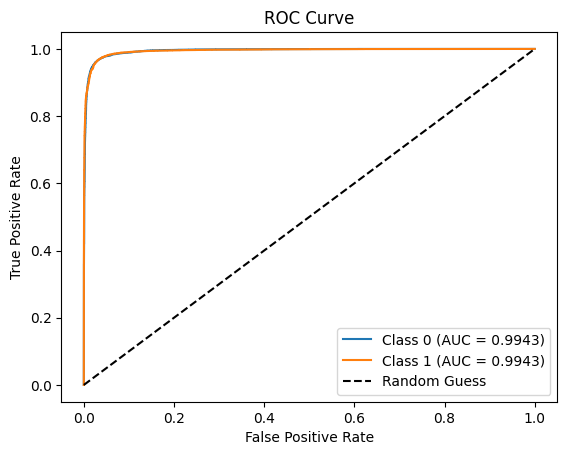

Model saved to /content/drive/MyDrive/Projects/Sentiment_Analysis/IMDB_sentiment_model_batch32_K5.pt!


In [11]:
if __name__ == "__main__":
    # Clone the repository and load the data
    # !git clone 'https://github.com/HoseinNekouei/sentiment_analysis.git'
    # file_path = '/content/sentiment_analysis/twitter_train_corpus.csv'
    file_path = '/content/drive/MyDrive/dataset/aspected_stanfordnlp_IMDB_train_corpus.csv'

    # Constants
    nrows= None
    N_SPLITS= 5 # k-fold
    EPOCHS = 2
    BATCH_SIZE = 32

    train_data = pd.read_csv(file_path, nrows= nrows) # Load your training data
    print(train_data.info())

    # Initialize the SentimentAnalysisModel class
    checkpoint= 'FacebookAI/roberta-base'
    # checkpoint= 'cardiffnlp/twitter-roberta-base-sentiment-latest'
    model = SentimentAnalysisModel(checkpoint, batch_size= BATCH_SIZE, epochs= EPOCHS, n_splits= N_SPLITS)

    # Perform k-fold cross-validation
    model.kfold_cross_validation(train_data)